# Introduction

`scikit-learn` is a powerful and user-friendly machine learning library for Python. It’s like a toolbox filled with tools that help you build and use machine learning models. The word “scikit” comes from “scientific kit,” emphasizing its focus on scientific and practical applications.

In simple terms, machine learning is a way for computers to learn from data and make predictions or decisions without being explicitly programmed. `scikit-learn` provides a set of tools to make this process easier and more accessible, especially for students who are learning about machine learning.

This notebook demonstrates two **full machine learning workflows** using:
1) Linear regression 
2) Logistic regression (classification)

You may not understand the full details of all of this right now.  That's ok!  The purpose of this notebook is to show the pipelines of two different types of problems, and how `scikit-learn` can help us!

## Linear Regression Pipeline with Fine-Tuning and Generalization Testing
- Preprocessing (imputation & scaling)
- Linear regression model
- Fine-tuning with GridSearchCV
- Held-out generalization testing

We'll use a synthetic dataset where **Salary depends on Years of Experience**.


In [1]:
## Import Libraries 

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt

### Create Synthetic Salary Data

We'll create a dataset of **Years of Experience vs Salary**, with some random noise.


In [2]:
## Create Synthetic Dataset (and have some missing values)

np.random.seed(42)
years = np.linspace(1, 10, 30)
salary = 30000 + 5000 * years + np.random.normal(0, 4000, size=years.shape)

X = pd.DataFrame({'YearsExperience': years})
y = pd.Series(salary, name="Salary")

# Add missing values randomly (10% missing)
missing_indices = np.random.choice(X.index, size=int(0.1 * len(X)), replace=False)
X.loc[missing_indices, 'YearsExperience'] = np.nan

print("Missing values in dataset:")
print(X.isnull().sum()) # Find the number of missing values

X.head(10)



Missing values in dataset:
YearsExperience    3
dtype: int64


,YearsExperience
0,NaN
1,1.310345
2,1.620690
3,1.931034
4,2.241379
5,2.551724
6,2.862069
7,3.172414
8,3.482759
9,3.793103


### Split Data into Train, Fine-Tune, and Generalization Sets

We hold out **20% for generalization**, then split the remaining data into **training (60%)** and **fine-tuning (20%)**.





<img src="attachment:86e0602c-3f93-495b-8e15-dc922bd8eac7.png" width="600">


In [3]:
## Data Splitting

X_temp, X_gen, y_temp, y_gen = train_test_split(X, y, test_size=0.2, random_state=42) #'Test'->'gen' for generalization

X_train, X_fine, y_train, y_fine = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42) #'Validation'->'fine' for fine tuning


### Define the Preprocessing and Pipeline

We'll use:
- **Imputer (mean)** to handle any missing values,
- **StandardScaler** to normalize features,
- **Ridge Regression** for modeling (supports regularization to prevent overfitting)... this is just to give you an idea of hyperparameter tuning!  We'll learn about ridge regression soon :)


In [4]:
## Preprocessing
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, X.columns)]
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])


### Train the Initial Model and Evaluate Generalization

We'll train the model on the training set and evaluate it on the **held-out generalization set**.


In [5]:
# --- 5. Train Initial Model ---
pipeline.fit(X_train, y_train)

# Evaluate on generalization set
y_pred_initial = pipeline.predict(X_gen)
mse_initial = mean_squared_error(y_gen, y_pred_initial)
r2_initial = r2_score(y_gen, y_pred_initial)

print("Generalization BEFORE Fine-Tuning")
print(f"  Mean Squared Error: {mse_initial:.2f}")
print(f"  R²: {r2_initial:.3f}")


Generalization BEFORE Fine-Tuning
  Mean Squared Error: 10152023.91
  R²: 0.910


## Fine-Tune the Model

We'll fine-tune the model using **GridSearchCV** on the combined training and fine-tuning sets.


In [6]:
X_combined = pd.concat([X_train, X_fine])
y_combined = pd.concat([y_train, y_fine])

param_grid = {
    'regressor__alpha': [0.01, 0.1, 1, 10],  # Ridge regularization strength
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_combined, y_combined)

print("Best Parameters After Fine-Tuning:")
grid_search.best_params_


Best Parameters After Fine-Tuning:


{'regressor__alpha': 1}

### Evaluate Generalization AFTER Fine-Tuning


In [7]:
y_pred_after = grid_search.predict(X_gen)
mse_after = mean_squared_error(y_gen, y_pred_after)
r2_after = r2_score(y_gen, y_pred_after)

print("Generalization AFTER Fine-Tuning")
print(f"  Mean Squared Error: {mse_after:.2f}")
print(f"  R²: {r2_after:.3f}")


Generalization AFTER Fine-Tuning
  Mean Squared Error: 8332866.62
  R²: 0.926


### Visualize it!

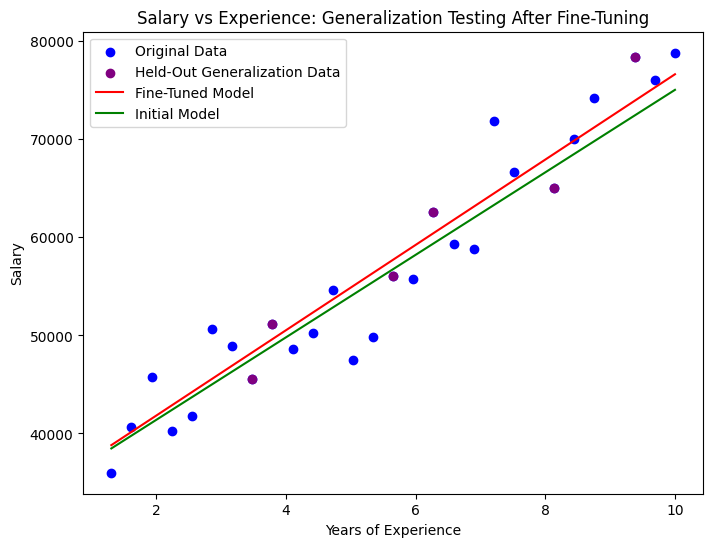

In [8]:
plt.figure(figsize=(8, 6))
plt.scatter(X, y, color='blue', label='Original Data')
plt.scatter(X_gen, y_gen, color='purple', label='Held-Out Generalization Data')

x_range = np.linspace(X['YearsExperience'].min(), X['YearsExperience'].max(), 100).reshape(-1, 1)
plt.plot(x_range, grid_search.predict(pd.DataFrame(x_range, columns=['YearsExperience'])), 
         color='red', label='Fine-Tuned Model')

plt.plot(x_range, pipeline.predict(pd.DataFrame(x_range, columns=['YearsExperience'])), 
         color='green', label='Initial Model')

plt.xlabel('Years of Experience')
plt.ylabel('Salary')
plt.title('Salary vs Experience: Generalization Testing After Fine-Tuning')
plt.legend()
plt.show()

#### What did we do??

- Used a pipeline for preprocessing + regression.

- Performed three-way split: training, fine-tuning, generalization.

- Fine-tuned via Ridge regularization (alpha parameter).

- Tested before and after fine-tuning on a held-out dataset.

## Logistic Regression with Preprocessing, Fine-Tuning, and Generalization Testing

This time we'll try this all with a classification problem.  Again, we'll: 

1. Preprocesses numerical features 
2. Trains a logistic regression classifier
3. Fine-tunes the model using hyperparameter search
4. Tests **generalization on a held-out dataset**

We'll use the **Iris dataset**, a classic classification problem.


In [8]:
## Import Libraries 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import joblib


### Load the Data

We load the Iris dataset and view its structure. The features are numeric, so we'll preprocess them with **imputation (mean)** and **standard scaling**.


In [9]:
## Load Data 
data = load_iris(as_frame=True)
X = data.data
y = data.target

X.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2


In [10]:
y.head() #This corrsponds with the iris 'type' 0, 1, and 2

0    0
1    0
2    0
3    0
4    0
Name: target, dtype: int64

### Create Train, Fine-Tune, and Generalization Test Sets

Again, to properly evaluate generalization, we will **Hold out 20%** of the data for a final generalization test. The we'll split the remaining 80% into **training (60%)** and **fine-tuning (20%)** sets.


In [11]:
## Data Splitting

X_temp, X_gen, y_temp, y_gen = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_fine, y_train, y_fine = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)


In [12]:
## Preprocessing

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[('num', numerical_transformer, X.columns)]
)


### Create and Train the Initial Model

We use a **Logistic Regression** classifier with the preprocessing steps wrapped in a single `Pipeline`.


In [13]:
# Initial Pipeline

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

pipeline.fit(X_train, y_train)


,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### Evaluate Generalization BEFORE Fine-Tuning

Remember... the held-out generalization set was **not used for training**.  
We now measure how well the model generalizes to unseen data.


In [14]:

y_pred_initial = pipeline.predict(X_gen)
acc_initial = accuracy_score(y_gen, y_pred_initial)

print("Generalization BEFORE Fine-Tuning")
print(f"  Accuracy: {acc_initial:.3f}")


Generalization BEFORE Fine-Tuning
  Accuracy: 0.967


### Fine-Tune the Model

We perform **hyperparameter tuning using GridSearchCV** on the **training + fine-tuning sets combined**.  
This simulates updating the model with more recent or expanded data.


In [19]:
X_combined = pd.concat([X_train, X_fine])
y_combined = pd.concat([y_train, y_fine])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'saga']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_combined, y_combined)

print("Best Parameters After Fine-Tuning:")
grid_search.best_params_


Best Parameters After Fine-Tuning:


{'classifier__C': 10,
 'classifier__penalty': 'l2',
 'classifier__solver': 'lbfgs'}

Again, you probably don't know what's going on here... that's ok!  This is just to show you how we'll tune these 'hyperparameters'.

### Evaluate Generalization AFTER Fine-Tuning

We now evaluate the fine-tuned model on the **same held-out generalization set** to see if generalization improved.


In [16]:
y_pred_after = grid_search.predict(X_gen)
acc_after = accuracy_score(y_gen, y_pred_after)

print("Generalization AFTER Fine-Tuning")
print(f"  Accuracy: {acc_after:.3f}")


Generalization AFTER Fine-Tuning
  Accuracy: 1.000


### Now let's visualize all that: 

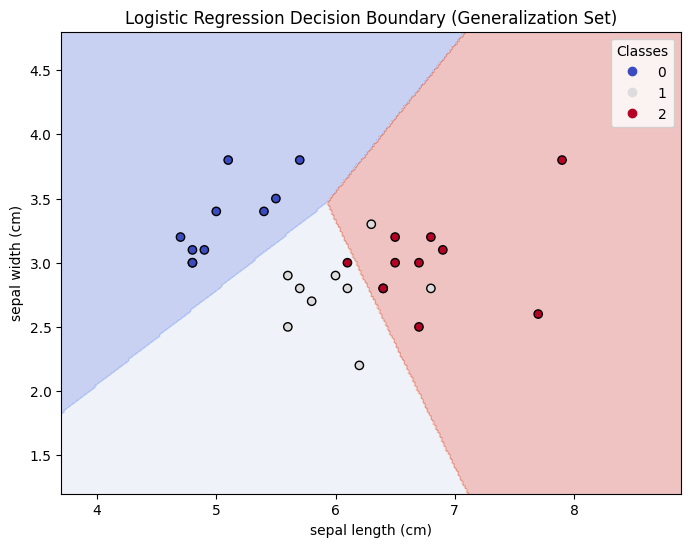

In [ ]:

# Define the features used for visualization
features_vis = ['sepal length (cm)', 'sepal width (cm)']

# Create a new pipeline for visualization with the selected features
pipeline_vis = Pipeline(steps=[
    ('preprocessor', ColumnTransformer(
        transformers=[('num', numerical_transformer, features_vis)]
    )),
    ('classifier', LogisticRegression(max_iter=1000))
])

# Perform GridSearchCV for the visualization pipeline
grid_search_vis = GridSearchCV(pipeline_vis, param_grid, cv=5, scoring='accuracy')
grid_search_vis.fit(X_combined[features_vis], y_combined)

best_pipeline = grid_search_vis.best_estimator_

# Define the features used for visualization
features_vis = ['sepal length (cm)', 'sepal width (cm)']

# Determine min/max from the generalization set
x_min, x_max = X_gen[features_vis[0]].min() - 1, X_gen[features_vis[0]].max() + 1
y_min, y_max = X_gen[features_vis[1]].min() - 1, X_gen[features_vis[1]].max() + 1

# Create the mesh grid
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

# Convert mesh grid to DataFrame with the same column names
mesh_df = pd.DataFrame(
    np.c_[xx.ravel(), yy.ravel()],
    columns=features_vis
)

# Predict decision regions
Z = best_pipeline.predict(mesh_df)
Z = Z.reshape(xx.shape)

# Plot decision boundary with generalization dataset
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
scatter = plt.scatter(X_gen[features_vis[0]], X_gen[features_vis[1]],
                      c=y_gen, edgecolor='k', cmap=plt.cm.coolwarm)

plt.xlabel(features_vis[0])
plt.ylabel(features_vis[1])
plt.title("Logistic Regression Decision Boundary (Generalization Set)")
plt.legend(*scatter.legend_elements(), title="Classes")
plt.show()

Hey what gives?? We've got an accuracy of 1... but some of these are clearly mismatched??? Well that's becuase we're actually using different models here — one trained on all features (grid_search), one on just two feature (grid_search_vis). So if evaluate accuracy using the same pipeline as this plot we actually get:

In [28]:
y_pred_vis = grid_search_vis.predict(X_gen[features_vis])
acc_vis = accuracy_score(y_gen, y_pred_vis)
print(f"Generalization Accuracy (2D features): {acc_vis:.3f}")


Generalization Accuracy (2D features): 0.900


### Done!

Ok so you might not have understood most of that... and that's ok!  This was just to get an idea of this library.  Hope you had fun!